# <b> Fake News Detector

### <b> Setup

In [49]:
import pandas as pd
import numpy as np
import seaborn as sea
from nltk import word_tokenize, FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score

stop_words = stopwords.words('english')
sea.set_style("darkgrid")

### <b> Data Access 

Data Source: https://www.kaggle.com/c/fake-news/data

In [2]:
train = pd.read_csv('train.csv')
train.shape

(20800, 5)

### <b> Exploratory Data Analysis

#### First Lines

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Dealing with Missing Values

In [4]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
train.fillna(' ', inplace=True)
train['aggregated_text'] = train[['title', 'text']].agg(' '.join, axis=1)
train = train[(train['title'] != ' ') & (train['text'] != ' ')]

#### Fake News Labels Distribution

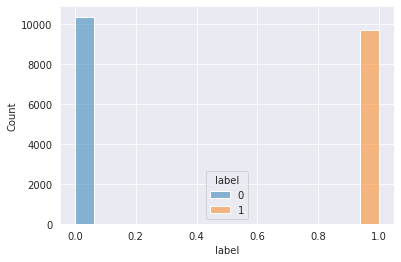

In [6]:
ax = sea.histplot(data=train, x="label", hue="label")

#### Cleaning Text 

In [29]:
'''
Function for remove symbols ans stopwords 
'''
def text_cleaning(text):
    try:
        words = word_tokenize(text) 
        text = [w.lower() for w in words if w not in string.punctuation and w.isalpha()]
        text = [w for w in text if w not in stop_words]
        return ' '.join(text)
    except:
        return text

In [ ]:
train.loc[:, 'clean'] = train['aggregated_text'].apply(lambda x: text_cleaning(x))

In [8]:
train[['aggregated_text', 'clean']].sample(10)

,aggregated_text,clean
1654,"Satire to resume writing itself November 9, 20...",satire resume writing november satire archetyp...
9621,Berkeley Protesters Demanding Segregation Forc...,berkeley protesters demanding segregation forc...
12627,"Hillary Is Elected President Monday, 14 Novemb...",hillary elected president monday november happ...
9763,"Reince Priebus, Normalizer in Chief - The New ...",reince priebus normalizer chief new york times...
1456,Swedish Finance Minister Admits ’Big Problems’...,swedish finance minister admits big problems e...
6603,Rand Paul Fires Back at John McCain: ’Past His...,rand paul fires back john mccain past prime li...
20733,Donald Trump Tackles ‘Totally Biased’ Today Sh...,donald trump tackles totally biased today show...
12431,Obama Loosens Restrictions on U.S. Forces Figh...,obama loosens restrictions forces fighting tal...
2364,Soros Spends $2 Million to Defeat Arpaio Soros...,soros spends million defeat arpaio soros spend...
4407,Comment on Donald Trump’s ex-wife Ivana says h...,comment donald trump ivana says make changes p...


#### Words Frequency

In [9]:
'''
Compute the frequency distibution of words from corpus 
'''
def words_frequency(tokens):

    # frequency of tokens
    text = FreqDist(tokens)
    
    # organize data in dataframe
    words_df = pd.DataFrame()
    words_df['words'] = text.keys()
    words_df['freq'] = text.values()
    
    # corpus unique words
    unique_words_quantity = len(set(tokens))
    # Normalize
    words_df['norm'] = [x/unique_words_quantity for x in words_df['freq']]
    return words_df.sort_values(by = 'freq', ascending=False)

def generate_tokens(df):
    #join all lines in a concise text
    sentences = df['clean']
    full_text = ''.join(sentences)

    # words as individual tokens
    return word_tokenize(full_text)

is_sarcasm_df = train[train['label'] == 1]
isnt_sarcasm_df = train[train['label'] == 0]

is_sarcasm_tokens = generate_tokens(is_sarcasm_df)
isnt_sarcasm_tokens = generate_tokens(isnt_sarcasm_df)

# words frequency in a dataframe
sarcasm_df_frequency = words_frequency(is_sarcasm_tokens)
not_sarcasm_df_frequency = words_frequency(isnt_sarcasm_tokens)

In [10]:
sarcasm_df_frequency.head(10)

,words,freq,norm
1213,trump,20386,0.152718
50,clinton,19527,0.146283
385,people,16351,0.122490
61,one,15405,0.115404
458,would,14466,0.108369
487,us,14221,0.106534
49,hillary,13248,0.099245
756,said,11734,0.087903
1321,new,10626,0.079603
37,like,10009,0.074981


In [11]:
not_sarcasm_df_frequency.head(10)

,words,freq,norm
152,said,67720,0.645906
186,trump,37834,0.360857
133,new,26258,0.250446
290,would,22856,0.217998
145,one,22600,0.215556
167,people,20000,0.190758
50,president,16987,0.162020
62,like,16077,0.153341
329,also,15530,0.148123
366,york,12891,0.122953


#### Wordclouds

In [12]:
def word_cloud(tokens):    
    frequency = FreqDist(tokens)
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequency)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

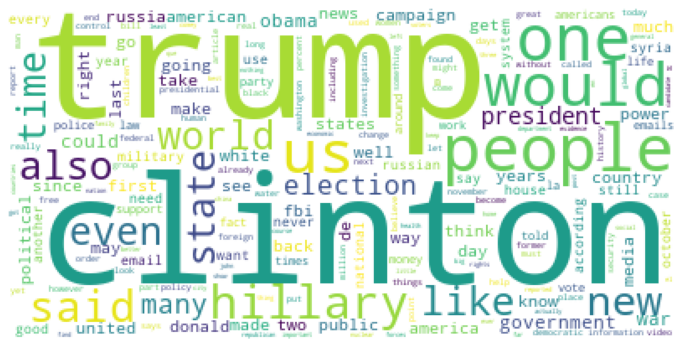

In [13]:
word_cloud(is_sarcasm_tokens)

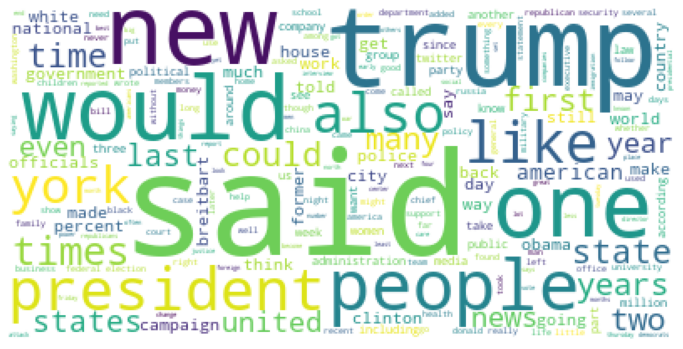

In [14]:
word_cloud(isnt_sarcasm_tokens)

### <b> Prepare Training Data

#### Encoding Data

In [15]:
vocab_size = 1000
embedding_dim = 50
max_length = 100
padding_type='post'
oov_tok = "<OOV>"

In [16]:
sentences = train['clean']
labels = train['label']

In [17]:
sentence_train, sentence_valid, label_train, label_valid = train_test_split(sentences, 
                                                                          labels, 
                                                                          test_size = 0.3, 
                                                                          random_state = 42)

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# build vocabulary
tokenizer.fit_on_texts(sentence_train)
vocabulary = tokenizer.word_index

In [19]:
# Features
train_sequences = tokenizer.texts_to_sequences(sentence_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(sentence_valid)
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

In [20]:
print("Original sentence = ", sentence_train.head(1))
print("\nTokenized sentence = ", train_sequences[0])
print("\nPadded sentence = ", train_padded_sequences[0])

Original sentence =  16618    glenne headly star dirty rotten scoundrels dic...
Name: clean, dtype: object

Tokenized sentence =  [1, 1, 794, 1, 1, 1, 1, 1, 1, 6, 30, 1, 1, 1, 249, 488, 1, 1, 1, 112, 253, 794, 1, 996, 693, 337, 205, 63, 1, 673, 313, 1, 842, 820, 1, 229, 1, 1, 1, 1, 1, 533, 1, 1, 1, 940, 1, 1, 1, 1, 1, 1, 1, 1, 996, 1, 1, 1, 1, 1, 1, 1, 805, 915, 1, 1, 1, 1, 257, 1, 479, 1, 1, 29, 916, 260, 1, 1, 1, 205, 1, 1, 1, 1, 322, 102, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 228, 1, 5, 168, 20, 885, 1, 1, 1, 885, 1, 1, 1, 1, 1, 1, 521]

Padded sentence =  [  1   1 112 253 794   1 996 693 337 205  63   1 673 313   1 842 820   1
 229   1   1   1   1   1 533   1   1   1 940   1   1   1   1   1   1   1
   1 996   1   1   1   1   1   1   1 805 915   1   1   1   1 257   1 479
   1   1  29 916 260   1   1   1 205   1   1   1   1 322 102   1   1   1
   1   1   1   1   1   1   1   1   1   1   1 228   1   5 168  20 885   1
   1   1 885   1   1   1   1   1   1 521]


### <b> Model Architecture
    

In [21]:
sentence_input = tf.keras.Input(shape=(max_length,))
embeddings_layer = tf.keras.layers.Embedding( input_dim = vocab_size+1, 
                                              input_length = max_length, 
                                              output_dim= embedding_dim, name='Embeddings')
x = embeddings_layer(sentence_input) 
x = tf.keras.layers.Conv1D(128, 5, activation="relu")(x)
x = tf.keras.layers.SpatialDropout1D(0.2)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(128)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    
model = tf.keras.Model(sentence_input, output, name="CNN_classifier")

model.compile(loss='binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                metrics=['accuracy'])   

In [22]:
model.summary()

Model: "CNN_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
Embeddings (Embedding)       (None, 100, 50)           50050     
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           32128     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 96, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)              

In [24]:
num_epochs = 20
history = model.fit(train_padded_sequences, 
                    label_train, 
                    epochs=num_epochs, 
                    validation_data=(valid_padded_sequences, label_valid), 
                    verbose=1)

Epoch 1/20
441/441 [==============================] - 2s 5ms/step - loss: 0.5077 - accuracy: 0.7109 - val_loss: 0.3060 - val_accuracy: 0.8667
Epoch 2/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2650 - accuracy: 0.8910 - val_loss: 0.2844 - val_accuracy: 0.8758
Epoch 3/20
441/441 [==============================] - 2s 5ms/step - loss: 0.1859 - accuracy: 0.9262 - val_loss: 0.3195 - val_accuracy: 0.8708
Epoch 4/20
441/441 [==============================] - 2s 4ms/step - loss: 0.1194 - accuracy: 0.9564 - val_loss: 0.3265 - val_accuracy: 0.8804
Epoch 5/20
441/441 [==============================] - 2s 4ms/step - loss: 0.0785 - accuracy: 0.9732 - val_loss: 0.4041 - val_accuracy: 0.8743
Epoch 6/20
441/441 [==============================] - 2s 4ms/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 0.5045 - val_accuracy: 0.8690
Epoch 7/20
441/441 [==============================] - 2s 4ms/step - loss: 0.0425 - accuracy: 0.9841 - val_loss: 0.5996 - val_accuracy: 0.8702
Epoch 

### <b> Results

In [41]:
predictions = model.predict(valid_padded_sequences)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0




Accuracy =  0.87
F1 =  0.87
Recall =  0.87



              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3139
           1       0.87      0.87      0.87      2900

    accuracy                           0.87      6039
   macro avg       0.87      0.87      0.87      6039
weighted avg       0.87      0.87      0.87      6039






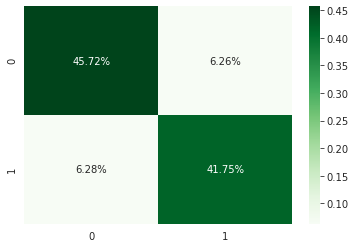

In [56]:
accuracy = accuracy_score(label_valid, predictions)
f1 = f1_score(label_valid, predictions)
recall = recall_score(label_valid, predictions)
print("\n\n")
print("Accuracy = ", np.round(accuracy, 2))
print("F1 = ", np.round(f1, 2))
print("Recall = ", np.round(recall, 2))
print("\n\n")

cf_matrix = confusion_matrix(label_valid, predictions)
print(classification_report(label_valid, predictions))
print("\n\n")
ax = sea.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Greens')

### <b> Making Predictions in New Data

#### Treat test Data to Predict

In [ ]:
test = pd.read_csv('test.csv')

test.fillna(' ', inplace=True)
test['aggregated_text'] = test[['title', 'text']].agg(' '.join, axis=1)

test.loc[:, 'clean'] = test['aggregated_text'].apply(lambda x: text_cleaning(x))

In [31]:
test[['aggregated_text', 'clean']].head()

,aggregated_text,clean
0,"Specter of Trump Loosens Tongues, if Not Purse...",specter trump loosens tongues purse strings si...
1,Russian warships ready to strike terrorists ne...,russian warships ready strike terrorists near ...
2,#NoDAPL: Native American Leaders Vow to Stay A...,nodapl native american leaders vow stay winter...
3,"Tim Tebow Will Attempt Another Comeback, This ...",tim tebow attempt another comeback time baseba...
4,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...,keiser report meme wars mins ago views comment...


In [80]:
sentence_test = test['clean']

test_sequences = tokenizer.texts_to_sequences(sentence_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

predictions = model.predict(test_padded_sequences)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

test.loc[:, 'is fake?'] = predictions
test['is fake?'] = test['is fake?'].apply(int)

In [81]:
test[['id', 'title', 'author', 'text', 'is fake?']].sample(10)

,id,title,author,text,is fake?
3045,23845,Neil Armstrong: 'Their Ships Were Far Superior...,,Neil Armstrong: 'Their Ships Were Far Superior...,1
1078,21878,"Democrats Urge Obama to Pardon 750,000 Illegal...",EdJenner,House Democrats are pushing President Obama to...,1
94,20894,The 5 Biggest Threats To Humanity Exposed,Whitney Webb,With attention squarely focused on the crimina...,1
656,21456,"If Trump Tweets It, Is It News? A Quandary for...",Michael M. Grynbaum and Sydney Ember,"Since Election Day, Donald J. Trump has prop...",0
1174,21974,"Yes, creationists can be real scientists, too",David Rives,About | | Archive David Rives is known for his...,1
1256,22056,Comment on A Humanitarian Crisis is Unfolding ...,geneww1938,Project Veritas Releases Fourth Video Exposing...,1
1177,21977,Baltimoreans Mourn a Man Said to Have Been Kil...,Rick Rojas,"BALTIMORE — Under a gloomy sky, a crowd of ...",0
5048,25848,Donald Trump Rebukes Ruth Bader Ginsburg for D...,Maggie Haberman,Donald J. Trump on Tuesday assailed Justice Ru...,0
1766,22566,Hearing Highlights: Sessions Questioned on Lin...,"Matt Apuzzo, Eric Lichtblau and Emmarie Huetteman",■ Senator Jeff Sessions of Alabama offered ass...,0
207,21007,Beyond the Anti-Trump Protests,Consortiumnews.com,"Beyond the Anti-Trump Protests November 17, 20...",0


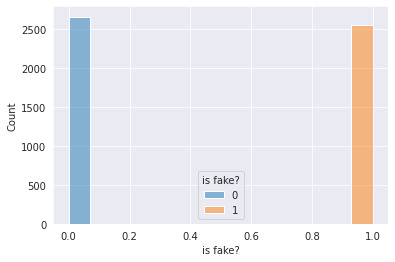

In [82]:
ax = sea.histplot(data=test, x="is fake?", hue="is fake?")